In [4]:
import pandas as pd
import numpy as np
import pickle
from datetime import datetime
from scipy.interpolate import UnivariateSpline
from fbprophet import Prophet
import seaborn as sns
import warnings
warnings.simplefilter(action='ignore')
import matplotlib.pyplot as plt
%matplotlib inline

In [17]:
# edit graph style here
sns.set()
plt.style.use('seaborn-paper')  # for poster use 'seaborn-poster'

Load in the historical data:

In [32]:
provinces = [10, 41, 50, 70, 90]
province_names = ['Bangkok', 'Udon Thani', 'Ratchaburi', 'Chiang Mai', 'Songkla']
years = [2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016]

true_data = pd.read_csv('../../data/province-month.csv')
true_data = true_data.loc[true_data['province'].isin(provinces) & true_data['date_sick_year'].isin(years)]
true_data['date_sick'] = true_data['date_sick_year'].map(str) + '-' + true_data['month'].map(str)
true_data['date_sick'] = pd.to_datetime(true_data['date_sick'])

# print(true_data.head())

k = 7
prov = 10

true_data_one_year = true_data.loc[(true_data['date_sick_year'] == 2007+k) & (true_data['province'] == prov) ]
print(true_data_one_year.head())

       date_sick_year  month  province  cases  date_sick
45759            2014      1        10  207.0 2014-01-01
45821            2014      2        10  157.0 2014-02-01
45884            2014      3        10  130.0 2014-03-01
45951            2014      4        10   80.0 2014-04-01
46015            2014      5        10   92.0 2014-05-01


Load in the data for Prophet:

In [28]:
with open('../../output/cv_df_list_prospective_monthly.pkl', 'rb') as file:
    data_file = pickle.load(file)


data = data_file[k]
data['year_month'] = (data['date_sick_year']-2006)*12 + (data['month'])

df = data.loc[input_data['province'] == prov]
df.tail()

,date_sick_year,month,province,cases,date_sick,year_month
45403,2013,8,10,1209.0,2013-8-1,92
45480,2013,9,10,937.0,2013-9-1,93
45556,2013,10,10,940.0,2013-10-1,94
45629,2013,11,10,940.0,2013-11-1,95
45699,2013,12,10,500.0,2013-12-1,96


Make the Prophet forecast for plotting

In [40]:
date_sick = np.array(data['date_sick'])
year = np.array(data['date_sick_year'])
cases = np.array(data['cases'])

df = pd.DataFrame(list(zip(date_sick, cases)), columns=['ds', 'y'])

# fit the prophet model
model = Prophet(interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(df)

# extend the dataframe and get the predictions
future_dates = model.make_future_dataframe(periods=12, freq='M')
past_and_forecast = model.predict(future_dates)
forecast = past_and_forecast.tail(12)

Make the other Prophet model for forecasting:

In [37]:
date_sick = np.array(data['date_sick'])
year = np.array(data['date_sick_year'])
cases = np.array(data['cases'])

df = pd.DataFrame(list(zip(date_sick, cases)), columns=['ds', 'y'])

# fit the prophet model
model = Prophet(changepoint_prior_scale= 0.5, interval_width=0.95, yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
model.fit(df)

# extend the dataframe and get the predictions
future_dates = model.make_future_dataframe(periods=12, freq='M')
past_and_forecast = model.predict(future_dates)
forecast2 = past_and_forecast.tail(12)

In [64]:
with open('../../output/cv_df_list_prospective_monthly.pkl', 'rb') as file:
    data_file = pickle.load(file)

input_data = data_file[k]
input_data['year_month'] = (input_data['date_sick_year']-2006)*12 + (input_data['month'])

df = input_data.loc[input_data['province'] == prov]

true_data = data_file[k+1]
true_data['year_month'] = (true_data['date_sick_year']-2006)*12 + (true_data['month'])

true_df = true_data.loc[true_data['province'] == prov]
true_df['date_sick'] == pd.to_datetime(true_df['date_sick'])
true_df.tail()

x = df['year_month'].tolist()
y = df['cases'].tolist()

y_sum = np.cumsum(y)

spl = UnivariateSpline(x, y_sum)

y_fit = spl(x)

y_smooth = np.diff(y_fit)
n = np.append(y_smooth[::-1], y_sum[0])
y_smooth = n[::-1]

df['smooth_cases'] = y_smooth

df.head()

monthly_avg = []
for i in range(1, 13):
    monthly_cases = df['smooth_cases'].loc[df['month'] == i].tolist()
    avg = np.mean(monthly_cases)
    monthly_avg.append(avg)

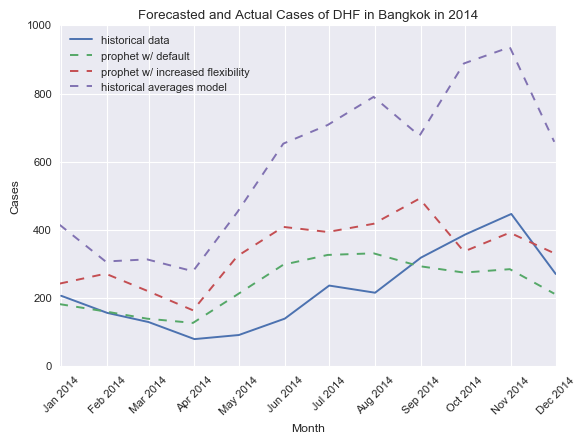

In [69]:
plt.xlabel('Month')
plt.ylabel('Cases')
plt.title('Forecasted and Actual Cases of DHF in Bangkok in 2014')
plt.xticks(rotation=45)

fig = plt.plot(true_data_one_year['date_sick'], true_data_one_year['cases'], '-', forecast['ds'], forecast['yhat'], '--', forecast2['ds'], forecast2['yhat'], '--', forecast['ds'], monthly_avg, '--')
plt.legend(['historical data', 'prophet w/ default', 'prophet w/ increased flexibility', 'historical averages model'], loc = 'upper_left')
plt.show()